In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Utils_Dipole.borisPush import borisPush

In [3]:
# create some particles
Lz = 327.7
Np = 10
xi = 8.62e-5
bcs = 2
T = 1000
dt = 0.05
wperp = 0.53
wpar = 0.2
me = 1
qe = -1
B0 = 1.0
Nt = np.int(T/dt)
tn = np.linspace(0,T,Nt+1)

particles = np.zeros((Nt+1,Np,5))
particles[0,:,0] = np.random.rand(Np)*Lz
particles[0,:,1] = np.random.randn(Np)*wperp
particles[0,:,2] = np.random.randn(Np)*wperp
particles[0,:,3] = np.random.randn(Np)*wpar
# ...

#particles[0,0,0] = 320
#particles[0,0,3] = 0.4

# define backgroud field
def B_background_z(z):
    return B0*(1 + xi*(z - Lz/2)**2)

def B_background(x,y,z):
    
    Bx = -x*(z - Lz/2)*B0*xi
    By = -y*(z - Lz/2)*B0*xi
    Bz = B0*(1 + xi*(z - Lz/2)**2)
    
    return np.transpose(np.array([Bx,By,Bz]))

Ep = np.zeros((Np,3))
Bp = np.zeros((Np,3))

Bp[:,2] = B_background_z(particles[0,:,0])
rho = -me/qe*np.cross(particles[0,:,1:4],np.array([0,0,1]))/Bp[:,2][:,None]
    
Bp[:,0:2] += B_background(rho[:,0],rho[:,1],particles[0,:,0])[:,0:2]

# initialize velocity
particles[0,:,1:4] = borisPush(particles[0],-dt/2,Bp,Ep,qe,me,Lz,bcs)[1]

# time integration
for n in range(0,Nt):
    Bp = np.zeros((Np,3))
    Bp[:,2] = B_background_z(particles[n,:,0])
    rho = -me/qe*np.cross(particles[n,:,1:4],np.array([0,0,1]))/Bp[:,2][:,None]
    
    Bp[:,0:2] += B_background(rho[:,0],rho[:,1],particles[n,:,0])[:,0:2]
    
    particles[n+1,:,0],particles[n+1,:,1:4] = borisPush(particles[n],dt,Bp,Ep,qe,me,Lz,bcs)

Text(0.5,0,'t')

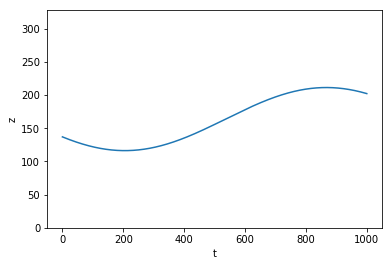

In [11]:
plt.plot(tn,particles[:,4,0])
plt.ylim((0,Lz))
plt.ylabel('z')
plt.xlabel('t')

In [41]:
from Utils_Dipole.createBasis import createBasis
from Utils_Dipole.matrixAssembly import matrixAssembly

Nel = 32
Lz = 327.7
p = 3
bcs = 2

def damp(z):
        
        if z <= Ld:
            return np.sin(np.pi*z/(2*Ld))
        elif z >= Lz-Ld:
            return np.sin(np.pi*(Lz-z)/(2*Ld))
        else:
            return 1.0
        
def dz_damp(z):
        
    if z <= Ld:
            return np.cos(np.pi*z/(2*Ld))*np.pi/(2*Ld)
    elif z >= Lz - Ld:
            return -np.cos(np.pi*(Lz-z)/(2*Ld))*np.pi/(2*Ld)
    else:
        return 0.0
bsp,N,quad_points,weights = createBasis(Lz,Nel,p,bcs)
M,C,D = matrixAssembly(bsp,p,Nel,weights,quad_points,B_background_z,bcs,damp,dz_damp)